In [1]:
%matplotlib inline
import numpy as np
import nmrglue as ng
import scipy.optimize
import matplotlib.pyplot as plt

# Test new version of ACME autophase with ACME and pmin implementation in nmrglue

This notebook contains a new implementation of the ACME algorithm. A trial NMR data set is processed with three different auto phase algorithems and the resulting spectra can be examined in an interactive plot

## Custom functions

In [2]:
def autops(data, fn, p0=0.0, p1=0.0, gamma=5.e-3, optreturn=False):
    """
    Automatic linear phase correction
    Parameters
    ----------
    data : ndarray
        Array of NMR data.
    fn : str or function
        Algorithm to use for phase scoring. Built in functions can be
        specified by one of the following strings: "acme", "peak_minima"
    p0 : float
        Initial zero order phase in degrees.
    p1 : float
        Initial first order phase in degrees.
    Returns
    -------
    ndata : ndarray
        Phased NMR data.
    """
    if not callable(fn):
        fn = {
            'peak_minima': _ps_peak_minima_score,
            'acme': _ps_acme_score,
        }[fn]

    opt = [p0, p1]
    
    opt = scipy.optimize.fmin(fn, x0=opt, args=(data, gamma))

    phasedspc = ps(data, p0=opt[0], p1=opt[1])
    if optreturn:
        return tuple(opt),phasedspc
    else:
        return phasedspc


def _ps_acme_score(ph, data, gamma):
    """
    Phase correction using ACME algorithm by Chen Li et al.
    Journal of Magnetic Resonance 158 (2002) 164-168
    Parameters
    ----------
    pd : tuple
        Current p0 and p1 values
    data : ndarray
        Array of NMR data.
    Returns
    -------
    score : float
        Value of the objective function (phase score)
    """

    phc0, phc1 = ph

    s0 = ps(data, p0=phc0, p1=phc1)
    data = np.real(s0)

    # Calculation of first derivatives
    ds1 = np.abs(np.diff(data,1))
    p1 = ds1 / np.sum(ds1)

    # Calculation of entropy
    h1 = -p1 * np.log(p1)
    h1s = np.sum(h1)

    # Calculation of penalty
    fr = p1
    fr[fr >= 0] = 0
    fr[fr < 0] = 1
    
    pr = gamma * np.sum(fr*p1**2)

    return h1s + pr

def _ps_peak_minima_score(ph, data,gamma):
    """
    Phase correction using simple minima-minimisation around highest peak
    This is a naive approach but is quick and often achieves reasonable
    results.  The optimisation is performed by finding the highest peak in the
    spectra (e.g. TMSP) and then attempting to reduce minima surrounding it.
    Parameters
    ----------
    pd : tuple
        Current p0 and p1 values
    data : ndarray
        Array of NMR data.
    Returns
    -------
    score : float
        Value of the objective function (phase score)
    """

    phc0, phc1 = ph

    s0 = ps(data, p0=phc0, p1=phc1)
    data = np.real(s0)

    i = np.argmax(data)
    mina = np.min(data[i-100:i])
    minb = np.min(data[i:i+100])

    return np.abs(mina - minb)

def ps(data, p0=0.0, p1=0.0, inv=False):
    """
    Linear phase correction
    Parameters
    ----------
    data : ndarray
        Array of NMR data.
    p0 : float
        Zero order phase in degrees.
    p1 : float
        First order phase in degrees.
    inv : bool, optional
        True for inverse phase correction
    Returns
    -------
    ndata : ndarray
        Phased NMR data.
    """
    p0 = p0 * np.pi / 180.  # convert to radians
    p1 = p1 * np.pi / 180.
    size = data.shape[-1]
    apod = np.exp(1.0j * (p0 + (p1 * np.arange(size) / size))
                  ).astype(data.dtype)
    if inv:
        apod = 1 / apod
    return apod * data

## Read  in spectra

In [3]:
expno=[10]
datapath=r'./T7947_20160226'

### From FID

In [4]:
path=datapath.replace('\\', '/')

Title=[]
tmp = []
for i,j in enumerate(expno):
    pathEnd='/%d/pdata/%d' % (j,1)
    data_dir=path+pathEnd
    pathTitle=data_dir+'/title'
    # From FID
    dic, data = ng.bruker.read(data_dir)
    # process the spectrum
    data = ng.bruker.remove_digital_filter(dic, data)
    data = ng.proc_base.ls(data, 1)                                                 # left shift
    data = ng.proc_base.gm(data, g2=1/15.0e3)                                       # To match proc data...
    data = ng.proc_base.zf_size(data, 2**16)                                        # zero fill
    data = ng.proc_base.fft_positive(data)                                          # fft
    
    # Try three different auto phase algorithms
    data_acme = ng.proc_autophase.autops(data, 
                           'acme', p0=-115., p1=44.)
    data_pmin = ng.proc_autophase.autops(data, 
                           'peak_minima', p0=-115., p1=44.) 
    data_pmin = ng.proc_base.ps(data_pmin, p0=180)
    
    opt, data_acme_new = autops(data, 
                           'acme', p0=-115., p1=44.,gamma=1.e-1,optreturn=True)
    data_acme_new = ng.proc_base.ps(data_acme_new, p0=180)
    opt, data_pmin_new = autops(data, 'peak_minima', p0=-115., p1=44.,optreturn=True)
    data_pmin_new = ng.proc_base.ps(data_pmin_new, p0=180)
    
    
    # Delete imaginaries
    data_acme = ng.proc_base.di(data_acme)                                                    
    data_acme_new = ng.proc_base.di(data_acme_new)                                                    
    data_pmin = ng.proc_base.di(data_pmin)
    data_pmin_new = ng.proc_base.di(data_pmin_new) 
    
    # Create ppm scales
    udic = ng.bruker.guess_udic(dic, data)
    uc1 = ng.fileiobase.uc_from_udic(udic)
    ppm_scale = uc1.ppm_scale()
    
    # store spectra
    if i ==  0:
        PPM = ppm_scale
        SPEC_acme = data_acme
        SPEC_acme_new = data_acme_new
        SPEC_pmin = data_pmin
        SPEC_pmin_new = data_pmin_new
        optphase=opt
    else:
        PPM = np.column_stack((PPM,ppm_scale))
        SPEC_acme = np.column_stack((SPEC_acme,data))
        SPEC_acme_new = np.column_stack((SPEC_acme_new,data_acme_new))
        SPEC_pmin = np.column_stack((SPEC_pmin,data_pmin))
        SPEC_pmin_new = np.column_stack((SPEC_pmin_new,data_pmin_new))
        optphase=np.row_stack((optphase,opt))

Optimization terminated successfully.
         Current function value: 100356912597921267712.000000
         Iterations: 80
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 2528.658200
         Iterations: 105
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 7.845184
         Iterations: 63
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 2528.658200
         Iterations: 105
         Function evaluations: 211


## Plot the three different processed spectra

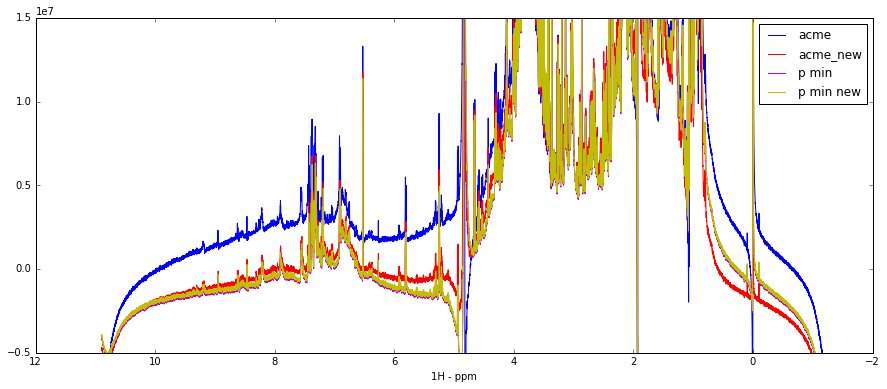

In [5]:
plt.plot(PPM,SPEC_acme,'b',label='acme')
plt.plot(PPM,SPEC_acme_new,'r',label='acme_new')
plt.plot(PPM,SPEC_pmin,'m',label='p min')
plt.plot(PPM,SPEC_pmin_new+1e5,'y',label='p min new')
plt.ylim([-5e6,15e6])
plt.xlabel('1H - ppm')
plt.gcf().set_size_inches(15, 6)              
plt.gca().invert_xaxis()
plt.legend()